In [7]:
! git clone https://github.com/eva-6-3/cnn_regularizations

fatal: destination path 'cnn_regularizations' already exists and is not an empty directory.


In [12]:
import sys
sys.path.append('./cnn_regularizations/utils/')

In [9]:
from data import MNIST_dataset
from misc import (
    show_random_images,
    get_device,
    set_seed,
    is_cuda,
    show_model_summary,
)
from model import Net
from training import train
from testing import test

In [10]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim
import numpy as np

### Device

In [11]:
set_seed()
cuda = is_cuda()
device = get_device()

[INFO] seed set 1
[INFO] Cuda Avaliable :  False
[INFO] device :  cpu


## Data Loader

In [6]:
train_loader = MNIST_dataset(
    train=True, cuda=cuda
).get_loader()
test_loader = MNIST_dataset(
    train=False, cuda=cuda
).get_loader()

KeyboardInterrupt: ignored

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


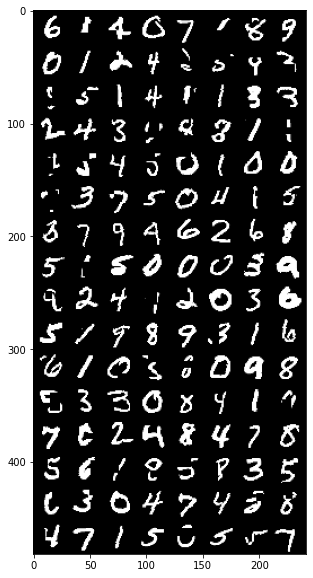

In [7]:
show_random_images(train_loader)

## Load Model

In [9]:
from tqdm.notebook import tqdm
import pandas as pd

In [48]:
"""
Network with Group Normalization + L1
Network with Layer Normalization + L2
Network with L1 + L2 + BN
"""
experiments= [
    {'BN': False, 'GN': True, 'LN': False, 'L1': True, 'L2': False},
    {'BN': False, 'GN': False, 'LN': True, 'L1': False, 'L2': True},
    {'BN': True, 'GN': False, 'LN': False, 'L1': True, 'L2': True},
]
EPOCHS = 25
results = {}
for exp in experiments:
    exp_name = ""
    for param, val in exp.items():
        if val:
            exp_name += f"{param}__"
    exp_name = exp_name.strip('__')
    print("Experiment : ", exp_name)
    results[exp_name] = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': [],
        'epoch': [],
    }

    net = Net(
        dropout_value=0.05, BN=exp['BN'], GN=exp['GN'], LN=exp['LN']
    ).to(device)
    show_model_summary(net)

    weight_decay = 1e-5 if exp['L2'] else 0
    optimizer = optim.SGD(
        net.parameters(), 
        lr=0.020, momentum=0.9, 
        weight_decay=weight_decay
    )
    lr_scheduler = ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, 
        patience=2, min_lr=0.001, verbose=True
    )

    for epoch in tqdm(range(1, EPOCHS + 1)):
        print(f"[EPOCH {epoch} / {EPOCHS}] -- ")
        train_loss_batch, train_acc_batch = train(
            net, device, 
            train_loader, 
            optimizer, 
            lr_scheduler,
            L1=exp['L1']
        )
        train_acc = np.mean(train_acc_batch)
        train_loss = np.mean(train_loss_batch)

        test_loss, test_acc = test(
            net, device, 
            test_loader,
            lr_scheduler
        )
        for metric in ['train_loss', 'train_acc', 'test_loss', 'test_acc', 'epoch']:
            results[exp_name][metric].append(eval(metric))

Experiment :  GN__L1
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 26, 26]              54
              ReLU-2            [-1, 6, 26, 26]               0
           Dropout-3            [-1, 6, 26, 26]               0
         GroupNorm-4            [-1, 6, 26, 26]              12
            Conv2d-5           [-1, 12, 24, 24]             648
              ReLU-6           [-1, 12, 24, 24]               0
           Dropout-7           [-1, 12, 24, 24]               0
         GroupNorm-8           [-1, 12, 24, 24]              24
            Conv2d-9            [-1, 7, 24, 24]              84
        MaxPool2d-10            [-1, 7, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,008
             ReLU-12           [-1, 16, 10, 10]               0
          Dropout-13           [-1, 16, 10, 10]               0
        GroupNorm-

[EPOCH 1 / 25] -- 


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))




Test set: Average loss: 0.5270, Accuracy: 8327/10000 (83.27%)

[EPOCH 2 / 25] -- 




Test set: Average loss: 0.5486, Accuracy: 8494/10000 (84.94%)

[EPOCH 3 / 25] -- 




Test set: Average loss: 0.4572, Accuracy: 8592/10000 (85.92%)

[EPOCH 4 / 25] -- 




Test set: Average loss: 0.6180, Accuracy: 8029/10000 (80.29%)

[EPOCH 5 / 25] -- 




Test set: Average loss: 0.5689, Accuracy: 8249/10000 (82.49%)

[EPOCH 6 / 25] -- 



Epoch     6: reducing learning rate of group 0 to 1.0000e-02.

Test set: Average loss: 0.5327, Accuracy: 8317/10000 (83.17%)

[EPOCH 7 / 25] -- 




Test set: Average loss: 0.4669, Accuracy: 8519/10000 (85.19%)

[EPOCH 8 / 25] -- 




Test set: Average loss: 0.4683, Accuracy: 8514/10000 (85.14%)

[EPOCH 9 / 25] -- 




Test set: Average loss: 0.3977, Accuracy: 8759/10000 (87.59%)

[EPOCH 10 / 25] -- 




Test set: Average loss: 0.4589, Accuracy: 8568/10000 (85.68%)

[EPOCH 11 / 25] -- 




Test set: Average loss: 0.4843, Accuracy: 8468/10000 (84.68%)

[EPOCH 12 / 25] -- 



Epoch    12: reducing learning rate of group 0 to 5.0000e-03.

Test set: Average loss: 0.4963, Accuracy: 8437/10000 (84.37%)

[EPOCH 13 / 25] -- 




Test set: Average loss: 0.5281, Accuracy: 8357/10000 (83.57%)

[EPOCH 14 / 25] -- 




Test set: Average loss: 0.3671, Accuracy: 8956/10000 (89.56%)

[EPOCH 15 / 25] -- 




Test set: Average loss: 0.4127, Accuracy: 8831/10000 (88.31%)

[EPOCH 16 / 25] -- 




Test set: Average loss: 0.3496, Accuracy: 8983/10000 (89.83%)

[EPOCH 17 / 25] -- 




Test set: Average loss: 0.3990, Accuracy: 8818/10000 (88.18%)

[EPOCH 18 / 25] -- 




Test set: Average loss: 0.3545, Accuracy: 8929/10000 (89.29%)

[EPOCH 19 / 25] -- 



Epoch    19: reducing learning rate of group 0 to 2.5000e-03.

Test set: Average loss: 0.3875, Accuracy: 8911/10000 (89.11%)

[EPOCH 20 / 25] -- 




Test set: Average loss: 0.3667, Accuracy: 8973/10000 (89.73%)

[EPOCH 21 / 25] -- 




Test set: Average loss: 0.3176, Accuracy: 9080/10000 (90.80%)

[EPOCH 22 / 25] -- 




Test set: Average loss: 0.3296, Accuracy: 9085/10000 (90.85%)

[EPOCH 23 / 25] -- 




Test set: Average loss: 0.3328, Accuracy: 9064/10000 (90.64%)

[EPOCH 24 / 25] -- 



Epoch    24: reducing learning rate of group 0 to 1.2500e-03.

Test set: Average loss: 0.3917, Accuracy: 8852/10000 (88.52%)

[EPOCH 25 / 25] -- 




Test set: Average loss: 0.3095, Accuracy: 9097/10000 (90.97%)


Experiment :  LN__L2
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 26, 26]              54
              ReLU-2            [-1, 6, 26, 26]               0
           Dropout-3            [-1, 6, 26, 26]               0
         GroupNorm-4            [-1, 6, 26, 26]              12
            Conv2d-5           [-1, 12, 24, 24]             648
              ReLU-6           [-1, 12, 24, 24]               0
           Dropout-7           [-1, 12, 24, 24]               0
         GroupNorm-8           [-1, 12, 24, 24]              24
            Conv2d-9            [-1, 7, 24, 24]              84
        MaxPool2d-10            [-1, 7, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,008
             ReLU-12           [-1, 16, 10, 10]               0
          Dropou

[EPOCH 1 / 25] -- 




Test set: Average loss: 0.0704, Accuracy: 9793/10000 (97.93%)

[EPOCH 2 / 25] -- 




Test set: Average loss: 0.0557, Accuracy: 9818/10000 (98.18%)

[EPOCH 3 / 25] -- 




Test set: Average loss: 0.0346, Accuracy: 9889/10000 (98.89%)

[EPOCH 4 / 25] -- 




Test set: Average loss: 0.0379, Accuracy: 9882/10000 (98.82%)

[EPOCH 5 / 25] -- 




Test set: Average loss: 0.0397, Accuracy: 9876/10000 (98.76%)

[EPOCH 6 / 25] -- 




Test set: Average loss: 0.0238, Accuracy: 9924/10000 (99.24%)

[EPOCH 7 / 25] -- 




Test set: Average loss: 0.0266, Accuracy: 9923/10000 (99.23%)

[EPOCH 8 / 25] -- 




Test set: Average loss: 0.0237, Accuracy: 9932/10000 (99.32%)

[EPOCH 9 / 25] -- 




Test set: Average loss: 0.0241, Accuracy: 9926/10000 (99.26%)

[EPOCH 10 / 25] -- 




Test set: Average loss: 0.0217, Accuracy: 9935/10000 (99.35%)

[EPOCH 11 / 25] -- 




Test set: Average loss: 0.0242, Accuracy: 9920/10000 (99.20%)

[EPOCH 12 / 25] -- 




Test set: Average loss: 0.0240, Accuracy: 9924/10000 (99.24%)

[EPOCH 13 / 25] -- 




Test set: Average loss: 0.0214, Accuracy: 9934/10000 (99.34%)

[EPOCH 14 / 25] -- 




Test set: Average loss: 0.0250, Accuracy: 9924/10000 (99.24%)

[EPOCH 15 / 25] -- 




Test set: Average loss: 0.0205, Accuracy: 9935/10000 (99.35%)

[EPOCH 16 / 25] -- 




Test set: Average loss: 0.0240, Accuracy: 9924/10000 (99.24%)

[EPOCH 17 / 25] -- 




Test set: Average loss: 0.0221, Accuracy: 9930/10000 (99.30%)

[EPOCH 18 / 25] -- 



Epoch    18: reducing learning rate of group 0 to 1.0000e-02.

Test set: Average loss: 0.0205, Accuracy: 9931/10000 (99.31%)

[EPOCH 19 / 25] -- 




Test set: Average loss: 0.0182, Accuracy: 9943/10000 (99.43%)

[EPOCH 20 / 25] -- 




Test set: Average loss: 0.0206, Accuracy: 9940/10000 (99.40%)

[EPOCH 21 / 25] -- 




Test set: Average loss: 0.0170, Accuracy: 9941/10000 (99.41%)

[EPOCH 22 / 25] -- 




Test set: Average loss: 0.0171, Accuracy: 9945/10000 (99.45%)

[EPOCH 23 / 25] -- 




Test set: Average loss: 0.0168, Accuracy: 9951/10000 (99.51%)

[EPOCH 24 / 25] -- 




Test set: Average loss: 0.0179, Accuracy: 9950/10000 (99.50%)

[EPOCH 25 / 25] -- 




Test set: Average loss: 0.0188, Accuracy: 9935/10000 (99.35%)


Experiment :  BN__L1__L2
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 26, 26]              54
              ReLU-2            [-1, 6, 26, 26]               0
           Dropout-3            [-1, 6, 26, 26]               0
       BatchNorm2d-4            [-1, 6, 26, 26]              12
            Conv2d-5           [-1, 12, 24, 24]             648
              ReLU-6           [-1, 12, 24, 24]               0
           Dropout-7           [-1, 12, 24, 24]               0
       BatchNorm2d-8           [-1, 12, 24, 24]              24
            Conv2d-9            [-1, 7, 24, 24]              84
        MaxPool2d-10            [-1, 7, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,008
             ReLU-12           [-1, 16, 10, 10]               0
          Dr

[EPOCH 1 / 25] -- 




Test set: Average loss: 0.8429, Accuracy: 7217/10000 (72.17%)

[EPOCH 2 / 25] -- 




Test set: Average loss: 0.9676, Accuracy: 6806/10000 (68.06%)

[EPOCH 3 / 25] -- 




Test set: Average loss: 0.4899, Accuracy: 8424/10000 (84.24%)

[EPOCH 4 / 25] -- 




Test set: Average loss: 0.4450, Accuracy: 8751/10000 (87.51%)

[EPOCH 5 / 25] -- 




Test set: Average loss: 0.9213, Accuracy: 6896/10000 (68.96%)

[EPOCH 6 / 25] -- 




Test set: Average loss: 0.4412, Accuracy: 8629/10000 (86.29%)

[EPOCH 7 / 25] -- 




Test set: Average loss: 0.5434, Accuracy: 8192/10000 (81.92%)

[EPOCH 8 / 25] -- 




Test set: Average loss: 0.6597, Accuracy: 7911/10000 (79.11%)

[EPOCH 9 / 25] -- 



Epoch     9: reducing learning rate of group 0 to 1.0000e-02.

Test set: Average loss: 0.5998, Accuracy: 8112/10000 (81.12%)

[EPOCH 10 / 25] -- 




Test set: Average loss: 0.4760, Accuracy: 8655/10000 (86.55%)

[EPOCH 11 / 25] -- 




Test set: Average loss: 0.3015, Accuracy: 9116/10000 (91.16%)

[EPOCH 12 / 25] -- 




Test set: Average loss: 0.5448, Accuracy: 8247/10000 (82.47%)

[EPOCH 13 / 25] -- 




Test set: Average loss: 0.9363, Accuracy: 6841/10000 (68.41%)

[EPOCH 14 / 25] -- 



Epoch    14: reducing learning rate of group 0 to 5.0000e-03.

Test set: Average loss: 1.3459, Accuracy: 5760/10000 (57.60%)

[EPOCH 15 / 25] -- 




Test set: Average loss: 0.2203, Accuracy: 9436/10000 (94.36%)

[EPOCH 16 / 25] -- 




Test set: Average loss: 0.2853, Accuracy: 9159/10000 (91.59%)

[EPOCH 17 / 25] -- 




Test set: Average loss: 0.2972, Accuracy: 9067/10000 (90.67%)

[EPOCH 18 / 25] -- 



Epoch    18: reducing learning rate of group 0 to 2.5000e-03.

Test set: Average loss: 0.4143, Accuracy: 8585/10000 (85.85%)

[EPOCH 19 / 25] -- 




Test set: Average loss: 0.2575, Accuracy: 9237/10000 (92.37%)

[EPOCH 20 / 25] -- 




Test set: Average loss: 0.1380, Accuracy: 9578/10000 (95.78%)

[EPOCH 21 / 25] -- 




Test set: Average loss: 0.1903, Accuracy: 9425/10000 (94.25%)

[EPOCH 22 / 25] -- 




Test set: Average loss: 0.2080, Accuracy: 9416/10000 (94.16%)

[EPOCH 23 / 25] -- 



Epoch    23: reducing learning rate of group 0 to 1.2500e-03.

Test set: Average loss: 0.2033, Accuracy: 9471/10000 (94.71%)

[EPOCH 24 / 25] -- 




Test set: Average loss: 0.1643, Accuracy: 9523/10000 (95.23%)

[EPOCH 25 / 25] -- 




Test set: Average loss: 0.2444, Accuracy: 9282/10000 (92.82%)




In [15]:
pd.DataFrame(results['GN__L1'])

,train_loss,train_acc,test_loss,test_acc,epoch
0,2.790895,58.033232,0.443329,86.73,0
1,1.857163,79.299519,0.602716,79.13,1
2,1.762354,79.277039,0.430783,86.86,2
3,1.734395,80.439128,0.433716,87.82,3
4,1.736310,81.005122,0.295942,92.11,4
5,1.728168,80.680598,0.369741,89.31,5
6,1.705212,80.766799,0.443085,86.52,6
7,1.719170,81.190831,0.393059,88.55,7
8,1.477621,84.308274,0.279056,92.00,8
9,1.469245,84.187955,0.279533,92.72,9


In [16]:
pd.DataFrame(results['LN__L2'])

,train_loss,train_acc,test_loss,test_acc,epoch
0,0.500779,68.629304,0.069758,97.97,0
1,0.147897,94.786016,0.041523,98.65,1
2,0.121266,95.849118,0.042884,98.61,2
3,0.109754,96.375622,0.038863,98.83,3
4,0.095090,96.944586,0.028237,99.04,4
5,0.093724,96.951145,0.028184,99.07,5
6,0.089244,96.849445,0.026032,99.19,6
7,0.086131,97.088074,0.032258,99.05,7
8,0.081255,97.348477,0.026730,99.19,8
9,0.078876,97.462807,0.026130,99.14,9


In [17]:
pd.DataFrame(results['BN__L1__L2'])

,train_loss,train_acc,test_loss,test_acc,epoch
0,2.650771,66.033795,0.620322,82.54,0
1,1.751013,84.604657,1.412943,56.13,1
2,1.666266,85.480606,1.097823,58.79,2
3,1.608792,86.197076,0.760407,72.76,3
4,1.355296,88.207620,0.435031,86.48,4
5,1.342449,87.968119,0.430712,87.13,5
6,1.328373,88.516121,0.651624,79.24,6
7,1.322218,88.390821,0.471658,84.20,7
8,1.332458,88.141640,0.407768,88.11,8
9,1.329799,88.431191,0.289510,91.01,9


In [21]:
exp_results = []
for experiment, result in results.items():
    print(experiment)
    df = pd.DataFrame(result)
    df['experiment_name'] = experiment
    exp_results.append(df)
exp_results_df = pd.concat(exp_results)

GN__L1
LN__L2
BN__L1__L2


In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

Text(0.5, 1.0, 'Training Loss')

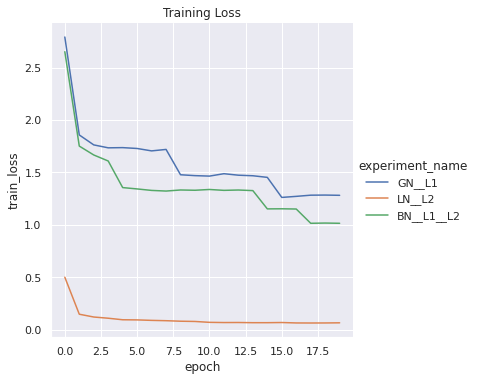

In [43]:
sns.relplot(data=exp_results_df, kind="line", x='epoch', y='train_loss', hue='experiment_name')
plt.title("Training Loss")

Text(0.5, 1.0, 'Training Accuracy')

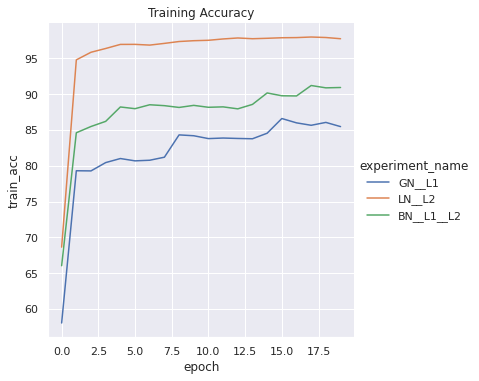

In [44]:
sns.relplot(data=exp_results_df, kind="line", x='epoch', y='train_acc', hue='experiment_name')
plt.title("Training Accuracy")

Text(0.5, 1.0, 'Testing Loss')

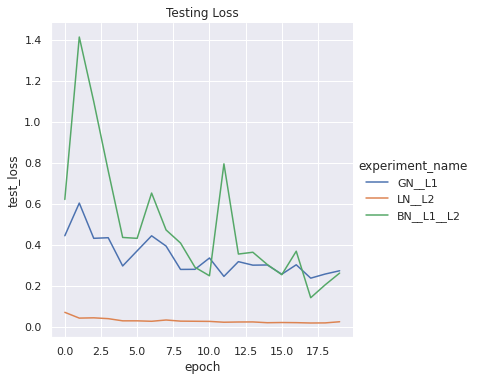

In [45]:
sns.relplot(data=exp_results_df, kind="line", x='epoch', y='test_loss', hue='experiment_name')
plt.title("Testing Loss")

Text(0.5, 1.0, 'Testing Accuracy')

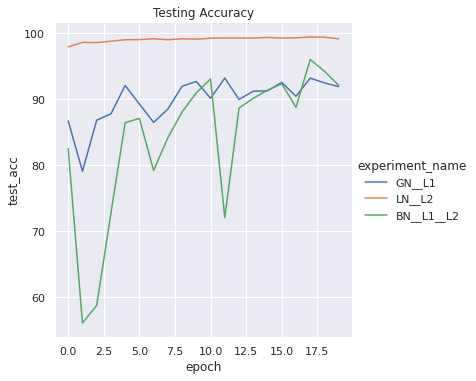

In [46]:
sns.relplot(data=exp_results_df, kind="line", x='epoch', y='test_acc', hue='experiment_name')
plt.title("Testing Accuracy")